# Torch Implementation of System Identification

## lib import

### imports

In [19]:
## NN
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# signals
import scipy.signal as signal
import numpy as np
from scipy.io import wavfile
# others
from tqdm import tqdm


In [20]:
a = torch.zeros(10)
print(a)
c = a.to(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### function define

In [21]:
def lowpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    lpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="lowpass", window=window)
    return lpf_firwin

def highpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    hpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="highpass",window=window)
    return hpf_firwin

def bandpass_firwin(ntaps, fl, fh,  fs, window='hamming'):
    nyq = 0.5 * fs
    bpf_firwin = signal.firwin(ntaps, [fl, fh], nyq=nyq, pass_zero=False, window=window)
    return bpf_firwin

def bandreject_firwin(ntaps, fl, fh,  fs, window='hamming'):
    nyq = 0.5 * fs
    brf_firwin = signal.firwin(ntaps, [fl, fh], nyq=nyq, window=window)
    return brf_firwin


def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

### Tool Box

In [100]:
print(f"epoch: {2}, audio: {3}")

epoch: 2, audio: 3


In [291]:
def plot_dictionary(result_dict, epoch_range, audio_range, title, result_type=1, reference_dict={}):
    num_audio = len(audio_range)
    num_epoch = len(epoch_range)
    if result_type == 1:
        plt.figure()
        fig, ax = plt.subplots(num_audio, num_epoch, figsize=(10*num_epoch, 2*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                if num_epoch == 1:                
                    ax[audio_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])])
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                else:               
                    ax[audio_idx, epoch_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])])
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')


    elif result_type == 2:
        plt.figure()
        fig, ax = plt.subplots(num_audio, 2*num_epoch, figsize=(20*num_epoch, 3*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                current_fir_lst = result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])]
                for i in range(len(current_fir_lst)):
                    current_fir = current_fir_lst[i]   
                    w, curr_freq_resp = signal.freqz(current_fir, 1)    
                    ax[audio_idx, 2*epoch_idx].plot(current_fir, label=f'{i} time stamp')
                    ax[audio_idx, 2*epoch_idx].set_title(f'Time Domain: Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, 2*epoch_idx].legend(loc ="upper right")
                    ax[audio_idx, 2*epoch_idx+1].plot(w, np.abs(curr_freq_resp), label=f'{i} time stamp')
                    ax[audio_idx, 2*epoch_idx+1].set_title(f'Frequency Domain {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, 2*epoch_idx+1].legend(loc ="upper right")
    elif result_type == 3:
        plt.figure()
        fig, ax = plt.subplots(num_audio, num_epoch, figsize=(10*num_epoch, 2*num_audio))
        for audio_idx in range(num_audio):
            for epoch_idx in range(num_epoch):
                curr_reference = reference_dict[audio_range[audio_idx]]
                curr_reference = curr_reference.detach().clone().cpu()
                print(curr_reference.shape)
                if num_epoch == 1:                
                    ax[audio_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])], alpha=0.3)
                    ax[audio_idx].plot(curr_reference, alpha=0.3)
                    ax[audio_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx].legend(["predict", "reference"])
                else:               
                    ax[audio_idx, epoch_idx].plot(result_dict[(epoch_range[epoch_idx], audio_range[audio_idx])], alpha=0.3)
                    ax[audio_idx, epoch_idx].plot(curr_reference, alpha=0.3)
                    ax[audio_idx, epoch_idx].set_title(f'Audio {audio_range[audio_idx]}, Epoch {epoch_range[epoch_idx]}')
                    ax[audio_idx, epoch_idx].legend(["predict", "reference"])
                


    
    
    plt.tight_layout()
    fig.suptitle(title)
    plt.show()
        

## Load Data and Data Loader

### Load Dataset (in cpu now)

In [77]:
def dataset_loader(address, index_range, length=1):
    input_dict = {}
    print('preparing input audio... ')
    for i in tqdm(range(len(index_range))):
        curr_name = str(index_range[i])
        addr = address + curr_name + '.wav'
        fs, data = wavfile.read('dataset/'+curr_name+'.wav')
        input_dict[i] = data[0:length*fs].astype('float64') / 32768
    return input_dict, fs

def generate_reference(input_dict, filter_type, ntaps, fs, fc=2000, fl=1000, fh=3000):
    # generate a fir filter
    if filter_type == 'lpf':
        filter_fir = lowpass_firwin(ntaps, fc, fs)
    elif filter_type == 'hpf':
        filter_fir = highpass_firwin(ntaps, fc, fs)
    elif filter_type == 'bpf':
        filter_fir = bandpass_firwin(ntaps, fl, fh, fs)
    elif filter_type == 'brf':
        filter_fir = bandreject_firwin(ntaps, fl, fh, fs)
        
        
    print('preparing reference audio... ')
    NT_1 = ntaps - 1
    reference_dict = {}
    for i in tqdm(range(len(input_dict))):
        input_audio = input_dict[i]
        reference_audio = np.convolve(input_audio, filter_fir, 'full')
        reference_dict[i] =reference_audio[NT_1: -NT_1] # torch.from_numpy(reference_audio).cuda()

    return reference_dict, filter_fir

In [165]:
input_dict, fs = dataset_loader('dataset', np.linspace(1, 60, 60,dtype=int))
reference_dict, filter_fir = generate_reference(input_dict, 'lpf', 32, fs, fc=2000)
N = len(input_dict)
print('number of dataset are: ', N)
print(fs)

preparing input audio... 


100%|██████████| 60/60 [00:00<00:00, 2134.38it/s]


preparing reference audio... 


100%|██████████| 60/60 [00:00<00:00, 1397.93it/s]

number of dataset are:  60
22050


Text(0.5, 1.0, 'system impulse response')

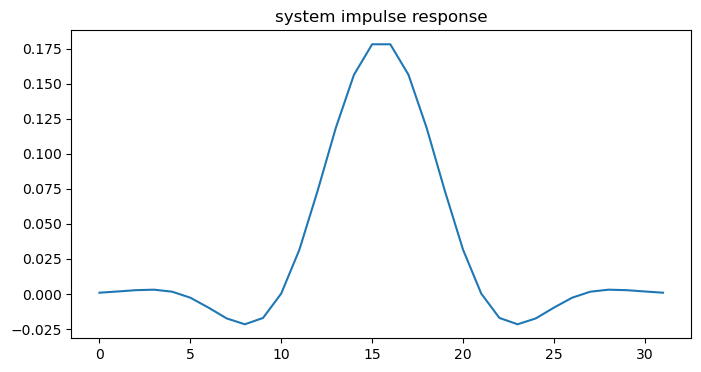

In [166]:
plt.figure(figsize=(8, 4))
plt.plot(filter_fir)
plt.title('system impulse response')

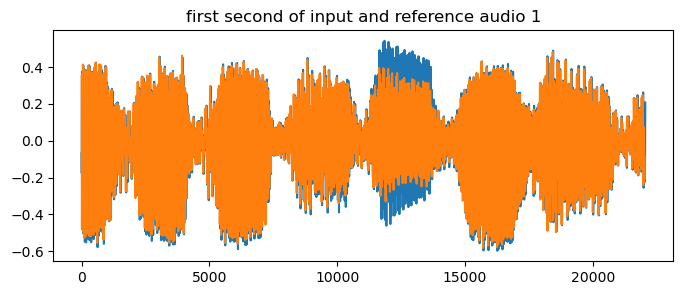

(22050,)
(22019,)


In [167]:
plt.figure(figsize=(8, 3))
plt.plot(input_dict[0])
plt.plot(reference_dict[0])
plt.title('first second of input and reference audio 1')
plt.show()

print(input_dict[0].shape)
print(reference_dict[0].shape)

### Make input data and reference data to cuda()

In [168]:
for i in tqdm(range(len(input_dict))):
    input_audio = input_dict[i]
    input_audio_gpu = torch.from_numpy(input_audio).cuda()
    input_dict[i] = input_audio_gpu
    
    reference_audio = reference_dict[i]
    reference_audio_gpu = torch.from_numpy(reference_audio).cuda()
    reference_dict[i] = reference_audio_gpu

100%|██████████| 60/60 [00:00<00:00, 4113.54it/s]


### Define data loader

In [169]:
class torch_sysid_loader(Dataset):
    def __init__(self, input_data, reference_data):
        self.input_data = input_data
        self.reference_data = reference_data

    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx:idx+32], self.reference_data[idx]

data_loader_dict = {}
for i in range(N):
    dset = torch_sysid_loader(input_dict[i], reference_dict[i])
    data_loader_dict[i] = dset #DataLoader(dset, batch_size=1, shuffle=False)


## Define Network and Optimizer

### Network

In [254]:
class AF_optimizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(65, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc8 = nn.Linear(128, 32)
        
    def forward(self, w):
        w = torch.sign(w) * torch.log1p(torch.abs(w))
        w = F.leaky_relu(self.fc1(w))
        w = F.leaky_relu(self.fc2(w))
        w = self.fc8(w)
        
        return w
    
torch_sysid = AF_optimizer().cuda()

### Optimizer and loss

In [255]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(torch_sysid.parameters(), lr=3e-4)

In [256]:
curr_data_loader = data_loader_dict[0]
idata, rdata = curr_data_loader[0]
print(idata, rdata, len(curr_data_loader))

tensor([-0.0686, -0.1224, -0.1550, -0.1733, -0.1771, -0.1549, -0.1115, -0.0424,
         0.0387,  0.1310,  0.2284,  0.3040,  0.3528,  0.3745,  0.3735,  0.3484,
         0.3149,  0.2681,  0.2003,  0.1244,  0.0360, -0.0736, -0.2047, -0.3422,
        -0.4395, -0.4778, -0.4808, -0.4645, -0.4357, -0.3957, -0.3459, -0.2826],
       device='cuda:0', dtype=torch.float64) tensor(0.3504, device='cuda:0', dtype=torch.float64) 22050


## Training (nn-sysid)

### Training Loop

In [257]:
loss_dict = {}
predict_dict = {}
filter_result_dict = {}
W = 32

for epoch in range(1):
    print("epoch: ", epoch)
    
    for j in range(5):
        print("audio: ", j)
        # initiate w
        init_w = torch.zeros(65, dtype=torch.float).cuda()
        w = torch_sysid(init_w)
        for k in range(w.shape[0]):
            w[k] = 0.0
            
        # pull out current data loader
        curr_data_loader = data_loader_dict[j]
        
        # backup a 'w' for later observation
        w_back_up = w.clone()

        loss = 0
        predict_lst = []
        loss_lst = []
        filter_result_lst = []
        filter_result_lst.append(w.detach().clone().cpu())
        
        
        num_steps = len(curr_data_loader)-W+1
        for i in tqdm(range(num_steps)):
            # =======================================================================================
            
            # get input and reference data, give it to GPU and adjust dtype
            input_data, reference_data = curr_data_loader[i]  
            
            # make everything in torch.float and to GPU (.cuda())
            input_data = torch.flatten(input_data.type(torch.float))
            reference_data = torch.flatten(reference_data.type(torch.float))     
            
            # cat all needed information (w, input_data, reference_data) to network's input
            network_in = torch.cat((w, input_data, reference_data))
            
            # calculate the output (dw)           
            w = torch_sysid(network_in)
            
            # =======================================================================================           
            cur_loss = loss_function(torch.dot(input_data, w), reference_data[0]).requires_grad_()
            loss = loss + cur_loss
            
            if i % 64 == 0 and i > 0:
                # calculate loss and do backward
                optimizer.zero_grad()
     
                loss.backward()
                optimizer.step()
                loss_lst.append(loss.item())
                w = w.detach().clone()

                loss = 0
            
            
            # =======================================================================================
            predict = torch.dot(input_data, w).clone()
            predict_lst.append(predict.detach().cpu().numpy())         
            
            if i % (num_steps // 5) == 0:
                filter_result_lst.append(w.detach().clone().cpu())
                
            

        
        filter_result_lst.append(w.detach().clone().cpu())
        predict_dict[(epoch, j)] = predict_lst
        loss_dict[(epoch, j)] = loss_lst
        filter_result_dict[(epoch, j)] =filter_result_lst


epoch:  0
audio:  0


100%|██████████| 22019/22019 [00:41<00:00, 532.36it/s]


audio:  1


100%|██████████| 22019/22019 [00:40<00:00, 548.65it/s]


audio:  2


100%|██████████| 22019/22019 [00:40<00:00, 546.11it/s]


audio:  3


100%|██████████| 22019/22019 [00:40<00:00, 540.29it/s]


audio:  4


100%|██████████| 22019/22019 [00:39<00:00, 554.71it/s]


### Examine Training Loss and Prediction

<Figure size 640x480 with 0 Axes>

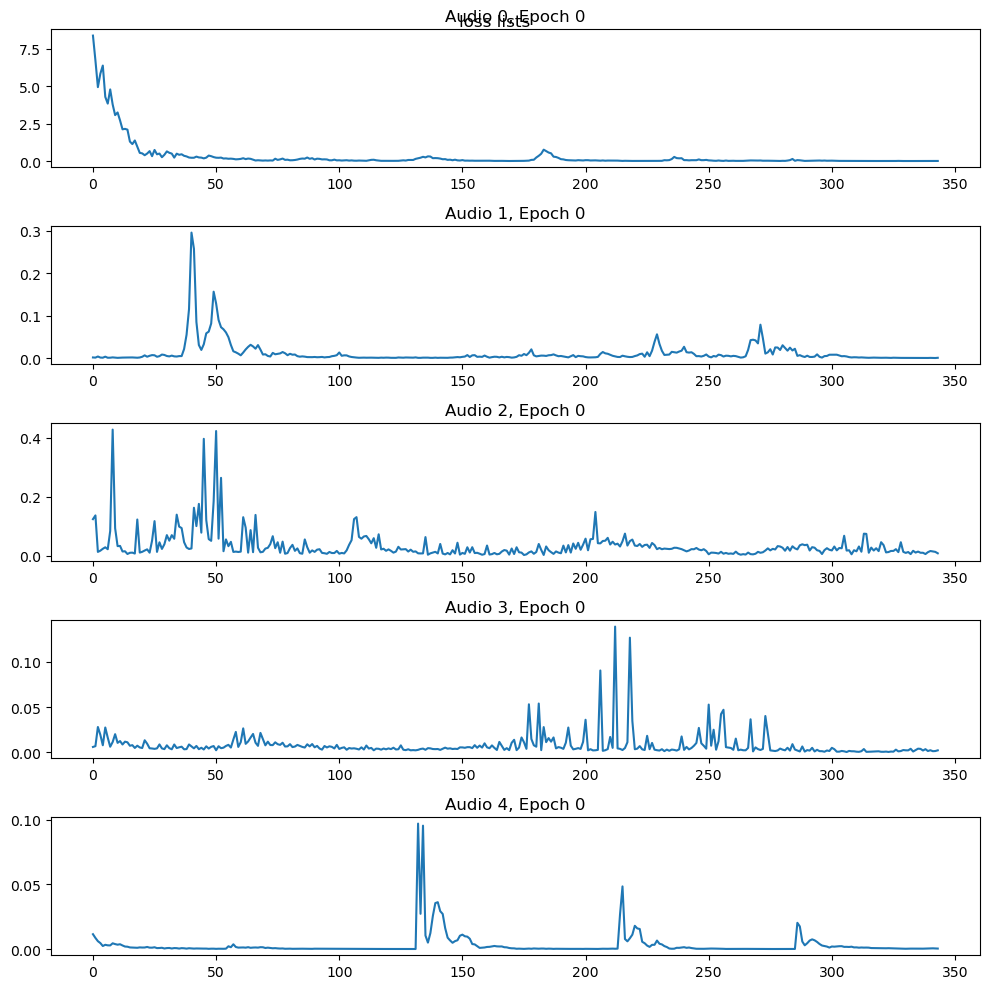

In [270]:
plot_dictionary(loss_dict, range(0, 1), range(0, 5), "loss lists", result_type=1)

<Figure size 640x480 with 0 Axes>

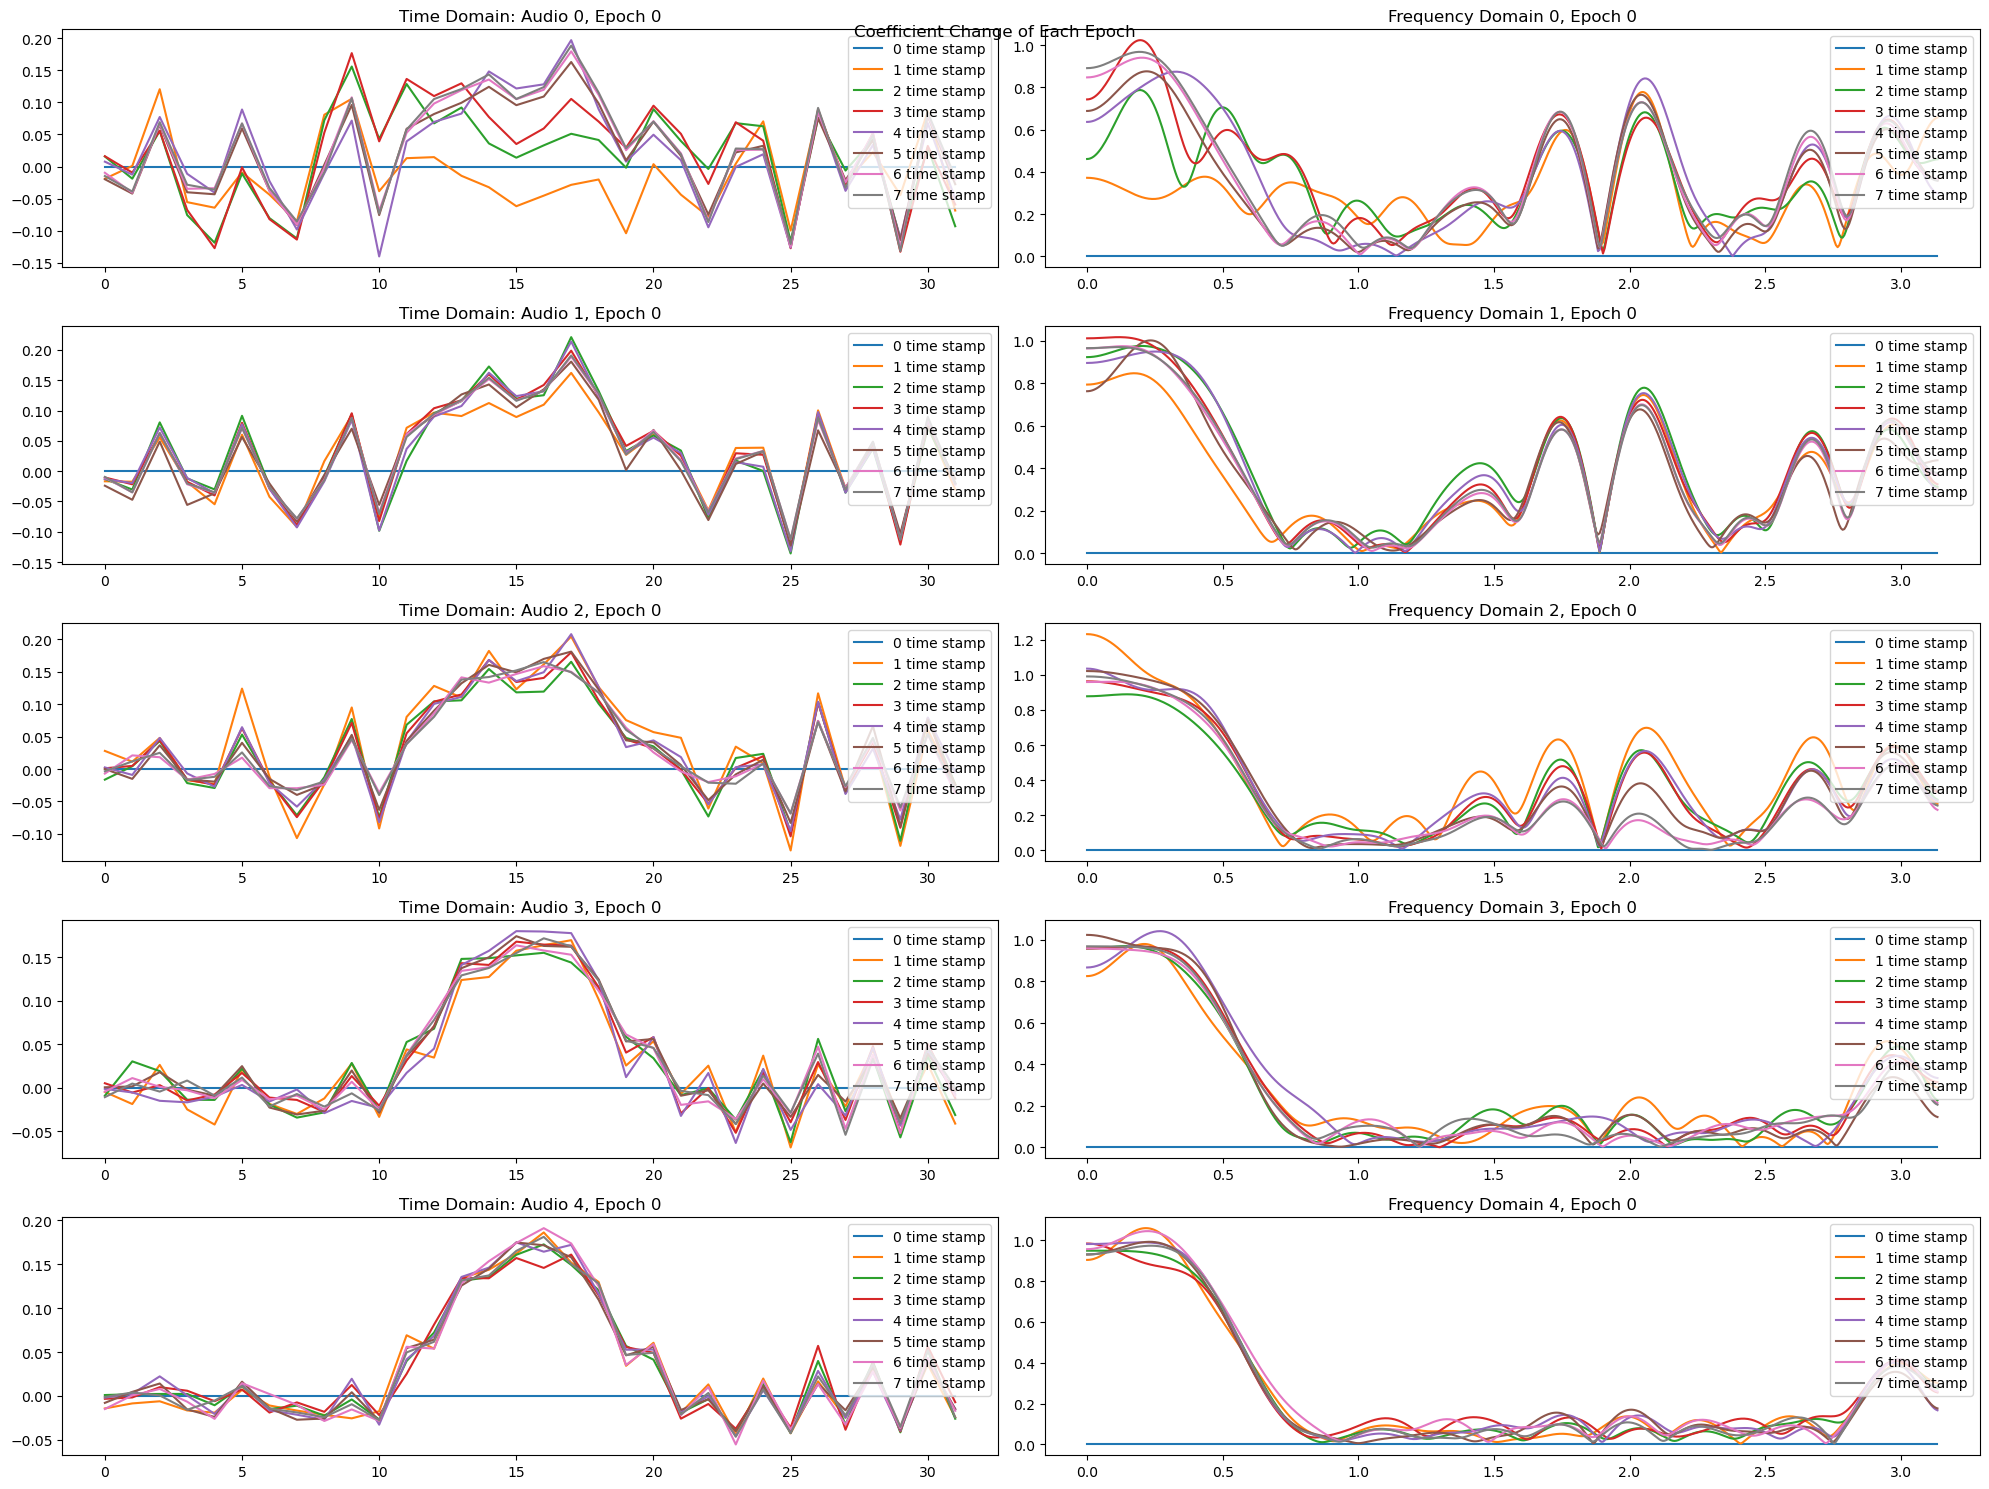

In [287]:
plot_dictionary(filter_result_dict, range(0, 1), range(0, 5), "Coefficient Change of Each Epoch", result_type=2)
# print(filter_result_dict)

torch.Size([22019])
torch.Size([22019])
torch.Size([22019])
torch.Size([22019])
torch.Size([22019])


<Figure size 640x480 with 0 Axes>

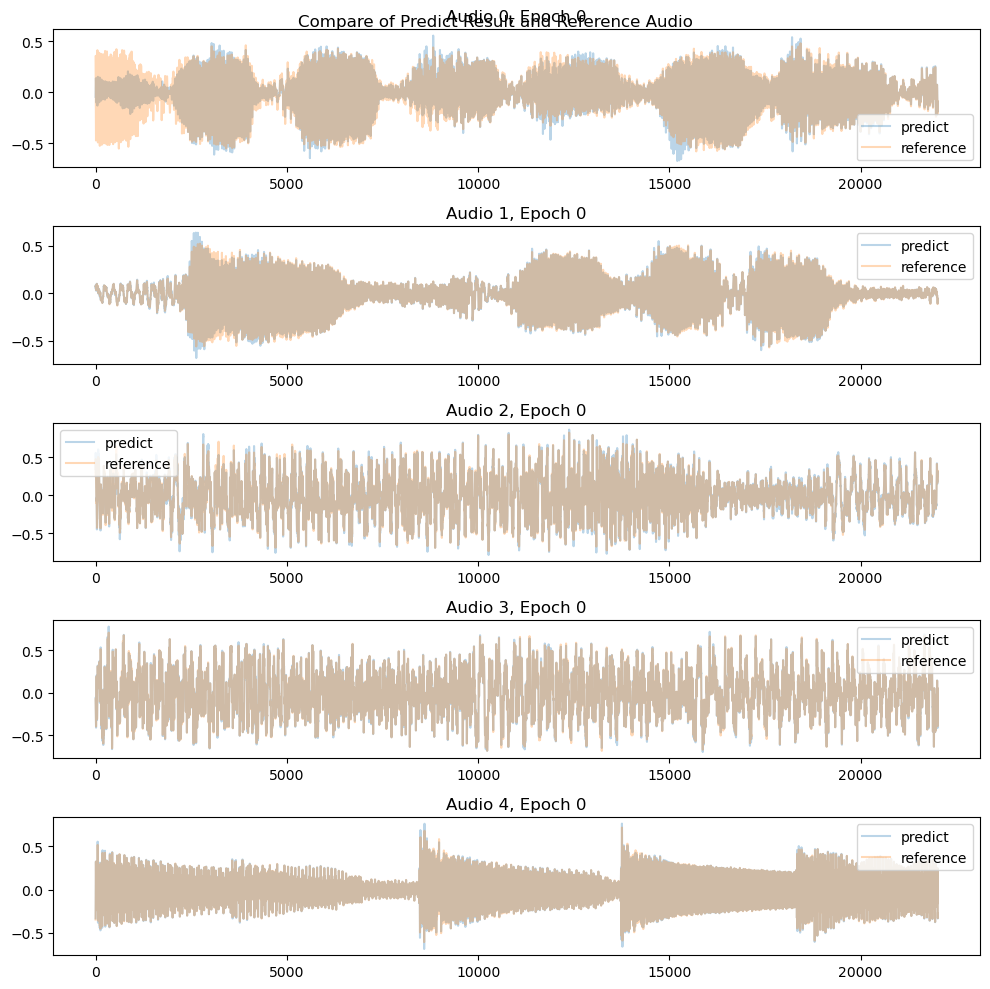

In [288]:
plot_dictionary(predict_dict,range(0, 1), range(0, 5), "Compare of Predict Result and Reference Audio", result_type=3, reference_dict=reference_dict)

## Test Loop

In [277]:
loss_dict_test = {}
predict_dict_test = {}
filter_result_dict_test = {}
W = 32

for epoch in range(1):
    print("epoch: ", epoch)
    
    for j in range(40, 43):
        print("audio: ", j)
        # initiate w
        init_w = torch.zeros(65, dtype=torch.float).cuda()
        w = torch_sysid(init_w)
        for k in range(w.shape[0]):
            w[k] = 0.0
            
        # pull out current data loader
        curr_data_loader = data_loader_dict[j]
        
        # backup a 'w' for later observation
        loss = 0
        predict_lst = []
        loss_lst = []
        filter_result_lst = []
        filter_result_lst.append(w.detach().clone().cpu())
        
        
        num_steps = len(curr_data_loader)-W+1
        for i in tqdm(range(num_steps)):
            # =======================================================================================
            
            # get input and reference data, give it to GPU and adjust dtype
            input_data, reference_data = curr_data_loader[i]  
            
            # make everything in torch.float and to GPU (.cuda())
            input_data = torch.flatten(input_data.type(torch.float))
            reference_data = torch.flatten(reference_data.type(torch.float))     
            
            # cat all needed information (w, input_data, reference_data) to network's input
            network_in = torch.cat((w, input_data, reference_data))
            
            # calculate the output            
            w = torch_sysid(network_in)
            
            # =======================================================================================
            predict = torch.dot(input_data, out).clone()
            predict_lst.append(predict.detach().cpu().numpy())                    
            loss = loss_function(torch.dot(input_data, out), reference_data[0]).requires_grad_()
            loss_lst.append(loss.item())
            
            if i % (num_steps // 5) == 0:
                filter_result_lst.append(w.detach().clone().cpu())
            
            
            # =======================================================================================
        
        
        filter_result_lst.append(w.detach().clone().cpu())
        print('at the end of audio:', j, "current loss is: ", loss.item())   
        predict_dict_test[(epoch, j)] = predict_lst
        loss_dict_test[(epoch, j)] = loss_lst
        filter_result_dict_test[(epoch, j)] = filter_result_lst


epoch:  0
audio:  40


100%|██████████| 22019/22019 [00:17<00:00, 1256.70it/s]


at the end of audio: 40 current loss is:  0.004912544973194599
audio:  41


100%|██████████| 22019/22019 [00:16<00:00, 1305.68it/s]


at the end of audio: 41 current loss is:  0.0009249633876606822
audio:  42


100%|██████████| 22019/22019 [00:16<00:00, 1375.97it/s]

at the end of audio: 42 current loss is:  0.039530713111162186


### Examine Test Result

<Figure size 640x480 with 0 Axes>

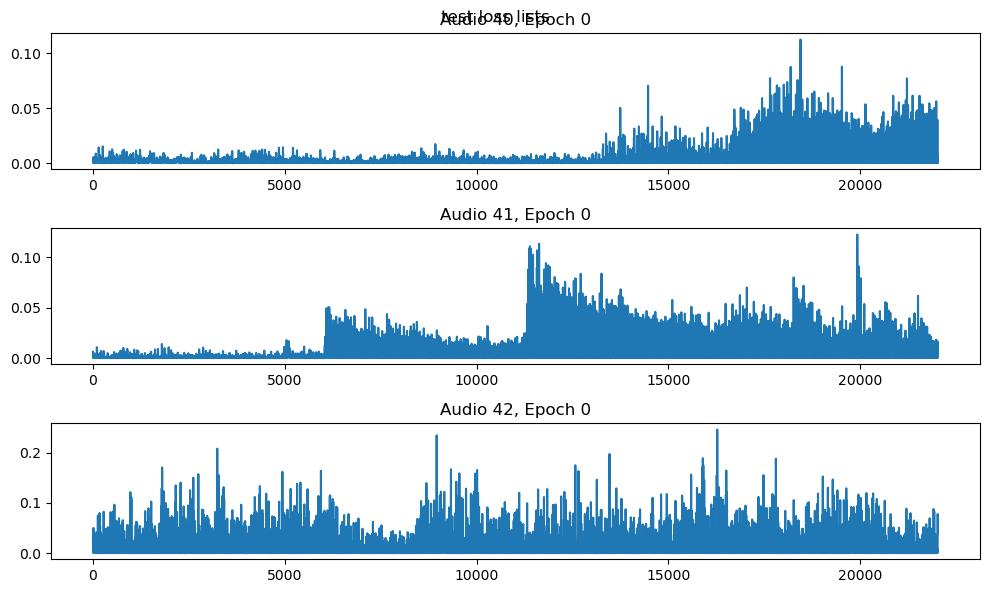

In [278]:
plot_dictionary(loss_dict_test, range(0, 1), range(40, 43), "test loss lists", result_type=1)

<Figure size 640x480 with 0 Axes>

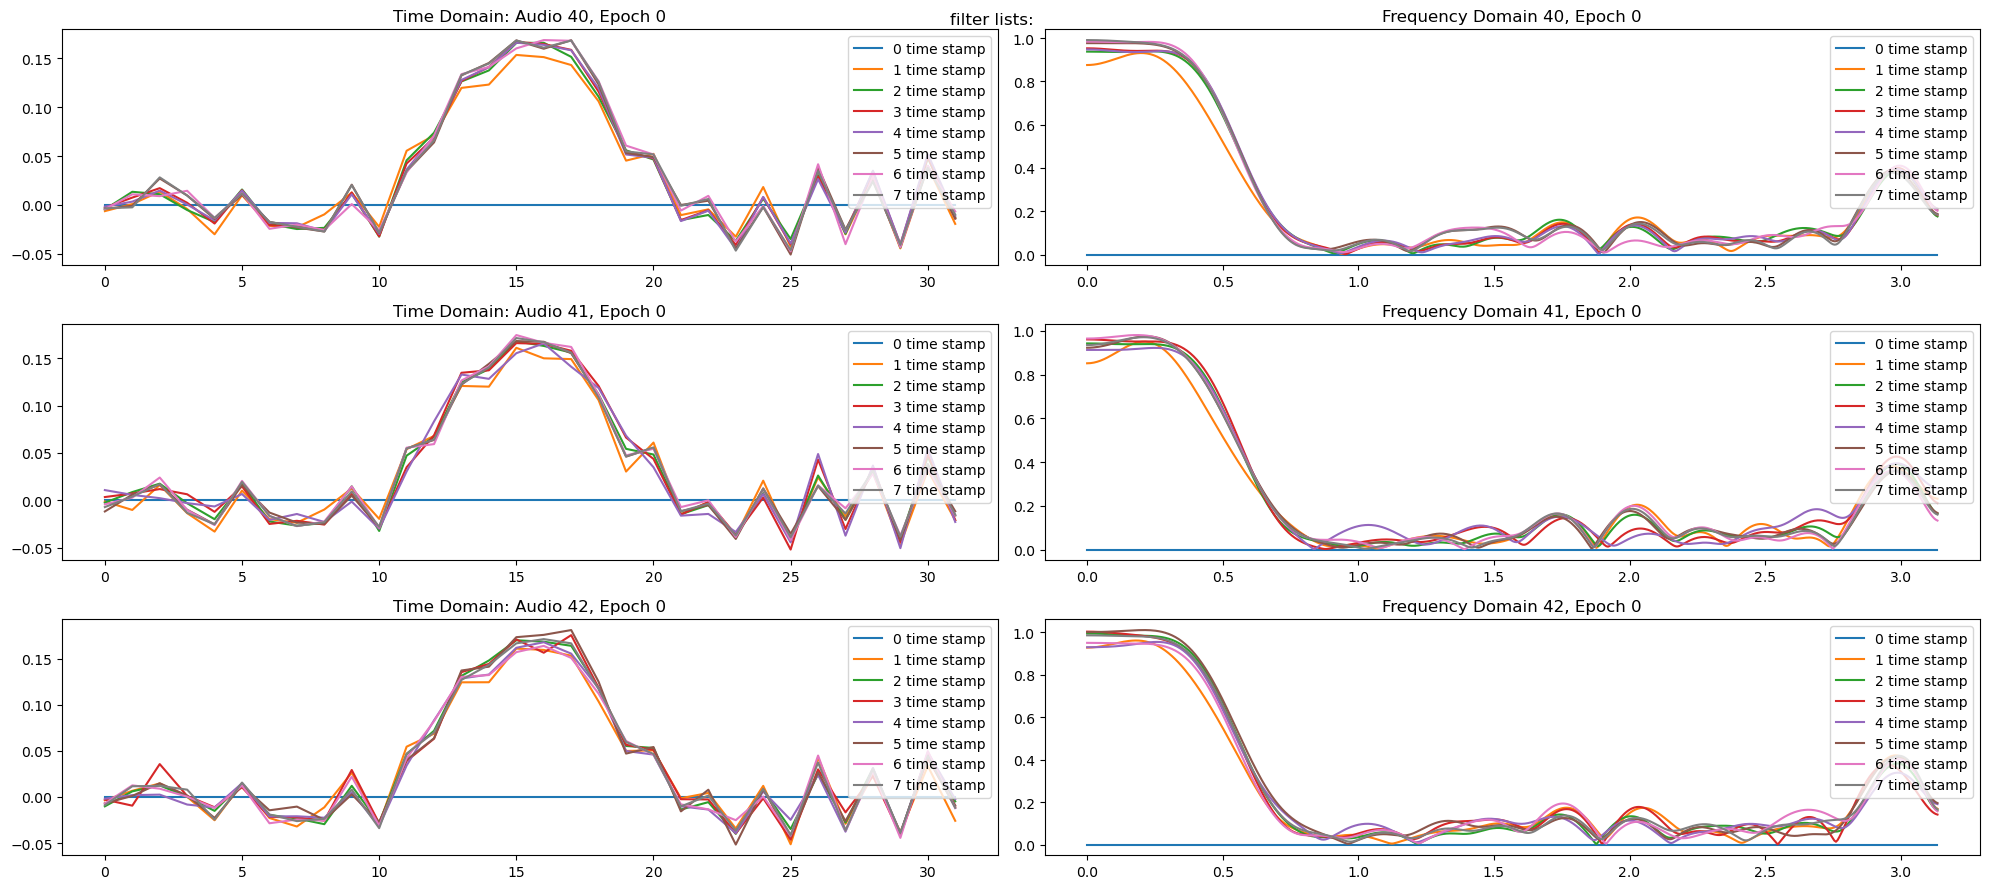

In [289]:
plot_dictionary(filter_result_dict_test, range(0, 1), range(40, 43), "filter lists: ", result_type=2)

torch.Size([22019])
torch.Size([22019])
torch.Size([22019])


<Figure size 640x480 with 0 Axes>

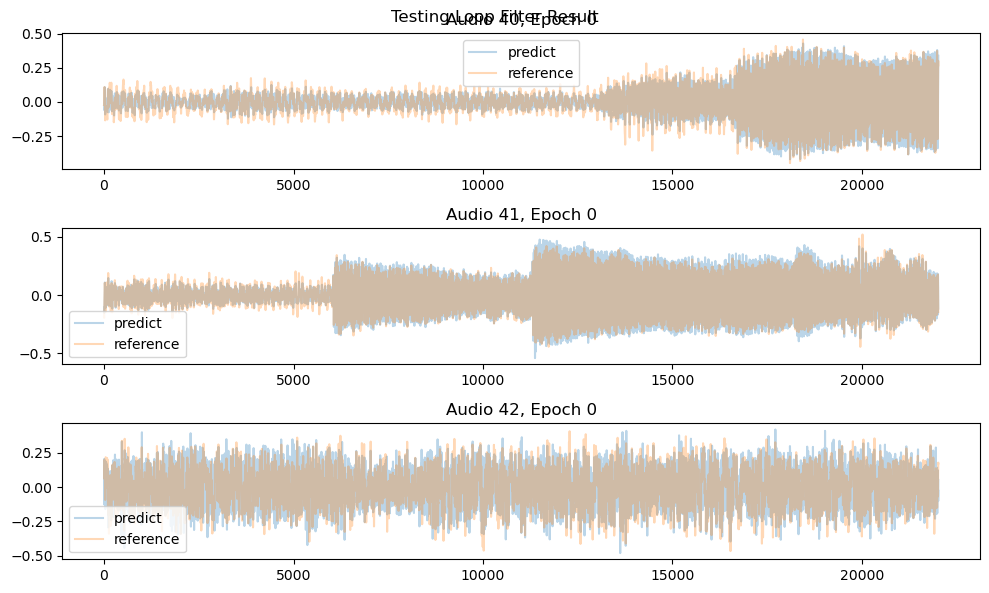

In [292]:
plot_dictionary(predict_dict_test, range(0, 1), range(40, 43), "Testing Loop Filter Result", result_type=3, reference_dict=reference_dict)

## Unused Modules

### LMS module

In [ ]:
# lr = 3e-10
# loss_lst = []
# predict_lst = []

# for epoch in range(5):
#     print("epoch: ", epoch)
    
#     for j in range(N):
#         print("audio: ", j)
#         # initiate w (all zero)
#         w = torch.zeros(32, dtype=torch.float).cuda()
                    
#         # pull out current data loader
#         curr_data_loader = data_loader_dict[j]
        
#         for i, data in tqdm(enumerate(curr_data_loader)):
#             # =======================================================================================
            
#             # get input and reference data, give it to GPU and adjust dtype
#             input_data, reference_data = data  
            
#             # make everything in torch.float and to GPU (.cuda())
#             input_data = torch.flatten(input_data.type(torch.float)).cuda()
#             reference_data = torch.flatten(reference_data.type(torch.float)).cuda()    
            
#             # predict output:
#             predict_data = torch.dot(torch.conj(w), input_data)
            
#             # calculate error and gradient direction
#             error = reference_data - predict_data
#             gradient = lr * torch.conj(error) * input_data
            
#             loss_lst.append(error[0].cpu())
# #             print(loss_lst)
# #             print('input data: ', input_data)
# #             print('w: ', w)            
# #             print('reference data: ', reference_data)
# #             print('predict_data: ', predict_data)
# #             print('loss: ', error)
            
#             # update coefficient
#             w += gradient
            
#             # record loss
            